In [1]:
# ==== Portable repo bootstrap (VS Code & Colab/Drive) ====
from pathlib import Path
import os, sys, csv

PROJECT_NAME = "einstein_program_synthesis"   # case-insensitive
def in_colab(): return "google.colab" in sys.modules or Path("/content").exists()

def _find_root_local():
    # walk up from CWD
    for p in [Path.cwd(), *Path.cwd().parents]:
        if (p / "scripts").exists():
            return p
    # scan common spots under HOME (case-insensitive)
    for base in [Path.home()/ "Documents"/ "Code", Path.home(), Path.cwd()]:
        if base.exists():
            for d in base.iterdir():
                if d.is_dir() and d.name.lower().replace(" ", "_") == PROJECT_NAME:
                    return d
    return None

def _find_root_drive():
    try:
        from google.colab import drive as _d; _d.mount("/content/drive")
    except Exception:
        pass
    md = Path("/content/drive/MyDrive")
    if not md.exists(): return None
    # exact first, then case-insensitive
    cand = md / PROJECT_NAME
    if cand.exists(): return cand
    for d in md.iterdir():
        if d.is_dir() and d.name.lower().replace(" ", "_") == PROJECT_NAME:
            return d
    return None

# Allow explicit override
ROOT = Path(os.getenv("EPS_ROOT")) if os.getenv("EPS_ROOT") else (
    _find_root_drive() if in_colab() else _find_root_local()
)
if ROOT is None or not ROOT.exists():
    raise FileNotFoundError("Repo root not found. Set EPS_ROOT=/full/path/to/EINSTEIN_PROGRAM_SYNTHESIS")

SCRIPTS_DIR = ROOT / "scripts"
sys.path.insert(0, str(SCRIPTS_DIR.resolve()))

def _find_data_dir(root: Path) -> Path:
    # env override wins
    if os.getenv("EPS_DATA_DIR"):
        return Path(os.getenv("EPS_DATA_DIR"))
    # try common layouts (your repo uses top-level output/)
    candidates = [
        root / "output",
        root / "outputs",
        root / "notebooks" / "output",
        root / "notebooks" / "outputs",
        root / "data",
    ]
    for c in candidates:
        if c.exists():
            return c
    raise FileNotFoundError(
        "DATA_DIR not found. Set EPS_DATA_DIR or create one of:\n" +
        "\n".join(f"- {c}" for c in candidates)
    )

DATA_DIR = _find_data_dir(ROOT)

print("ROOT     :", ROOT.resolve())
print("SCRIPTS  :", SCRIPTS_DIR.resolve())
print("DATA_DIR :", DATA_DIR.resolve())
print("CSV files:", [p.name for p in DATA_DIR.glob("*.csv")])

# ---- One-column CSV loader (header + ints/'nan'/blank -> None) ----
def load_indices(fname: str, base: Path = DATA_DIR):
    path = base / fname
    if not path.exists():
        seen = ", ".join(sorted(p.name for p in base.glob("*.csv")))
        raise FileNotFoundError(f"{path} not found. In {base} I see: {seen}")
    out = []
    with path.open(newline="") as f:
        reader = csv.reader(f)
        next(reader, None)  # skip header
        for row in reader:
            s = (row[0] if row else "").strip().lower()
            out.append(None if s in {"", "none", "nan"} else int(s))
    return out

# ---- Example usage ----
success_indices_enum  = load_indices("success_indices_enum.csv")
success_indices_bayes = load_indices("success_indices_pure_bayes.csv")
success_indices       = load_indices("success_indices_bayes_neural.csv")


ROOT     : /home/omar/Documents/Code/einstein_program_synthesis
SCRIPTS  : /home/omar/Documents/Code/einstein_program_synthesis/scripts
DATA_DIR : /home/omar/Documents/Code/einstein_program_synthesis/output
CSV files: ['enum_stats.csv', 'success_indices_bayes_neural.csv', 'success_indices_pure_bayes.csv', 'pure_bayes_stats.csv', 'success_indices_enum.csv', 'bayes_neural_stats.csv']


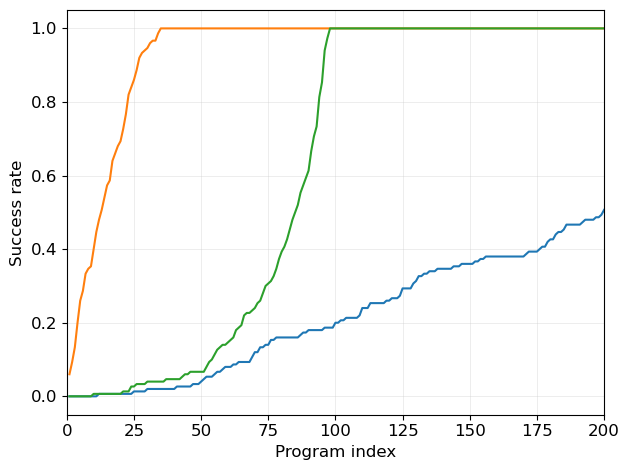

In [2]:
import matplotlib.pyplot as plt
import numpy as np

enum_results      = success_indices_enum    
purebayes_results = success_indices_bayes 
hybrid_results    = success_indices   

# ─── Filter out the runs that never succeeded ───
enum_hits      = np.array([i for i in enum_results      if i is not None])
purebayes_hits = np.array([i for i in purebayes_results if i is not None])
hybrid_hits    = np.array([i for i in hybrid_results    if i is not None])

MAX_SAMPLES = 200 # 1000
N_RUNS = 150

x = np.arange(1, MAX_SAMPLES+1)

# ─── Build each curve: fraction of runs with hit ≤ k ───
sr_enum   = np.array([np.sum(enum_hits   <= k)/N_RUNS   for k in x])
sr_pure   = np.array([np.sum(purebayes_hits <= k)/N_RUNS for k in x])
sr_hybrid = np.array([np.sum(hybrid_hits  <= k)/N_RUNS for k in x])

# ─── Plot them together ───
plt.figure()
plt.plot(x, sr_enum,   label='Enumeration')
plt.plot(x, sr_pure,   label='Pure-Bayes')
plt.plot(x, sr_hybrid, label='Bayes-Neural')
plt.xlabel('Program index',   fontsize=12)
plt.ylabel('Success rate',   fontsize=12)
# plt.title('Success Rate over Program Index') #Not show title
# plt.legend() #OAC: Not show legend
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Force x-axis from 0 to max_program
plt.xlim(0, MAX_SAMPLES)

# plt.grid(True)

# Grid a bit darker/heavier
plt.grid(
    True,
    color='#CCCCCC',    # darker gray
    linewidth=0.6,      # slightly thicker
    linestyle='-',
    alpha=0.4           # more opaque
)

# # ─── remove top & right spines ────────────────────────────────────
# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# # ───────────────────────────────────────────────────────────────────

plt.tight_layout()
plt.show()